# Module 5.4: Data Fusion and Preprocessing

## Combined Case Study: Cybersecurity, Edge AI and Autonomous Driving

---

## Objective

Demonstrate how to combine and preprocess multimodal data from autonomous driving and cybersecurity contexts, preparing it for Edge AI modeling.

**Key Learning Goals:**
- Understand data fusion challenges in Connected and Autonomous Vehicles (CAVs)
- Learn to synchronize asynchronous multimodal data streams
- Master preprocessing techniques for heterogeneous data types
- Prepare integrated datasets for edge AI deployment

---

## Why Data Fusion Matters in CAVs

Connected and Autonomous Vehicles (CAVs) operate in complex environments where:

1. **Physical Safety**: Vehicle sensors (LiDAR, cameras, GPS) monitor road conditions and obstacles
2. **Cybersecurity**: Network monitoring detects malicious attacks on vehicle communication systems
3. **Edge Processing**: Real-time decisions require fast, local processing with limited computational resources

**Challenge**: Physical sensor data and network traffic data have different:
- Sampling rates (telemetry: 10Hz, network: variable)
- Data formats (numerical vs. categorical)
- Timestamp precision (milliseconds vs. seconds)

**Solution**: Data fusion techniques that align, normalize, and combine these streams for unified anomaly detection.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import random

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

## Step 1: Generate Synthetic Datasets

We'll create two realistic datasets representing:
1. **Vehicle Telemetry**: Physical sensor data from autonomous driving systems
2. **Network Traffic Logs**: Cybersecurity monitoring data from vehicle communication systems

In [2]:
def generate_telemetry_data(n_samples=500, duration_minutes=30):
    """
    Generate realistic vehicle telemetry data
    
    Parameters:
    - n_samples: Number of telemetry records
    - duration_minutes: Time span of the simulation
    
    Returns:
    - DataFrame with vehicle sensor data
    """
    
    print(f"Generating {n_samples} vehicle telemetry records...")
    
    # Generate timestamps (every ~3.6 seconds for 30 minutes)
    start_time = datetime.now() - timedelta(minutes=duration_minutes)
    time_intervals = np.linspace(0, duration_minutes*60, n_samples)
    timestamps = [start_time + timedelta(seconds=t) for t in time_intervals]
    
    # Simulate realistic driving patterns
    # Speed varies between 0-100 km/h with traffic patterns
    base_speed = 50 + 30 * np.sin(np.linspace(0, 4*np.pi, n_samples))  # Traffic patterns
    speed = np.maximum(0, base_speed + np.random.normal(0, 5, n_samples))
    
    # Acceleration correlates with speed changes
    acceleration = np.diff(np.concatenate([[speed[0]], speed])) + np.random.normal(0, 0.5, n_samples)
    
    # Distance to obstacle (closer in urban areas, farther on highways)
    urban_factor = 0.5 + 0.5 * np.sin(np.linspace(0, 6*np.pi, n_samples))
    distance_to_obstacle = 10 + 40 * urban_factor + np.random.exponential(5, n_samples)
    
    # GPS coordinates (simulated route)
    base_lat, base_lon = 40.7128, -74.0060  # NYC area
    gps_lat = base_lat + np.cumsum(np.random.normal(0, 0.0001, n_samples))
    gps_lon = base_lon + np.cumsum(np.random.normal(0, 0.0001, n_samples))
    
    # Brake status (categorical: 0=off, 1=light, 2=heavy)
    brake_prob = np.where(acceleration < -2, 0.8, 0.1)  # Brake when decelerating
    brake_status = np.random.choice([0, 1, 2], n_samples, p=[0.7, 0.25, 0.05])
    brake_status = np.where(np.random.random(n_samples) < brake_prob, 
                           np.random.choice([1, 2], n_samples), brake_status)
    
    # Create DataFrame
    telemetry_df = pd.DataFrame({
        'timestamp': timestamps,
        'speed': np.round(speed, 2),
        'acceleration': np.round(acceleration, 3),
        'distance_to_obstacle': np.round(distance_to_obstacle, 2),
        'gps_lat': np.round(gps_lat, 6),
        'gps_lon': np.round(gps_lon, 6),
        'brake_status': brake_status
    })
    
    print(f"Generated telemetry data: {len(telemetry_df)} records")
    print(f"   Time range: {telemetry_df['timestamp'].min()} to {telemetry_df['timestamp'].max()}")
    
    return telemetry_df

# Generate larger vehicle telemetry dataset for balanced training
telemetry_data = generate_telemetry_data(n_samples=3000, duration_minutes=90)

# Display sample data
print("\nSample Vehicle Telemetry Data:")
print(telemetry_data.head(10))
print(f"\nTelemetry Data Shape: {telemetry_data.shape}")

Generating 3000 vehicle telemetry records...
Generated telemetry data: 3000 records
   Time range: 2025-09-24 17:38:46.685322 to 2025-09-24 19:08:46.685322

Sample Vehicle Telemetry Data:
                   timestamp  speed  acceleration  distance_to_obstacle  \
0 2025-09-24 17:38:46.685322  52.48        -0.954                 32.05   
1 2025-09-24 17:38:48.485922  49.43        -3.479                 31.31   
2 2025-09-24 17:38:50.286522  53.49         3.849                 32.13   
3 2025-09-24 17:38:52.087123  57.99         5.446                 31.36   
4 2025-09-24 17:38:53.887723  49.33        -8.382                 42.11   
5 2025-09-24 17:38:55.688323  49.46        -0.542                 33.16   
6 2025-09-24 17:38:57.488923  58.65         9.435                 32.16   
7 2025-09-24 17:38:59.289523  54.72        -4.707                 33.85   
8 2025-09-24 17:39:01.090124  48.66        -5.518                 32.94   
9 2025-09-24 17:39:02.890724  53.84         4.950             

In [3]:
def generate_network_data(n_samples=500, duration_minutes=30):
    """
    Generate realistic network traffic logs for vehicle communication systems
    
    Parameters:
    - n_samples: Number of network log entries
    - duration_minutes: Time span of the simulation
    
    Returns:
    - DataFrame with network monitoring data
    """
    
    print(f"Generating {n_samples} network traffic records...")
    
    # Generate timestamps with slight offset and variation from telemetry
    start_time = datetime.now() - timedelta(minutes=duration_minutes)
    # Network logs more frequent but irregular
    time_intervals = np.sort(np.random.uniform(0, duration_minutes*60, n_samples))
    timestamps = [start_time + timedelta(seconds=t) for t in time_intervals]
    
    # Source and destination IP addresses (vehicle communication)
    vehicle_ips = ['192.168.1.10', '192.168.1.11', '192.168.1.12']  # Vehicle internal network
    external_ips = ['8.8.8.8', '1.1.1.1', '10.0.0.1', '172.16.0.1']  # External services
    
    src_ips = np.random.choice(vehicle_ips + external_ips, n_samples)
    dst_ips = np.random.choice(vehicle_ips + external_ips, n_samples)
    
    # Protocol types (TCP, UDP, ICMP for vehicle communications)
    protocols = np.random.choice(['TCP', 'UDP', 'ICMP'], n_samples, p=[0.6, 0.35, 0.05])
    
    # Packet counts (bursts during active communication)
    base_packets = np.random.poisson(lam=10, size=n_samples)
    burst_factor = np.random.choice([1, 5, 20], n_samples, p=[0.8, 0.15, 0.05])  # Occasional bursts
    packet_count = base_packets * burst_factor
    
    # Bytes transferred (correlates with packet count)
    bytes_per_packet = np.random.normal(1500, 500, n_samples)  # Average Ethernet frame size
    bytes_transferred = np.maximum(64, packet_count * np.maximum(64, bytes_per_packet))
    
    # Port numbers (common vehicle communication ports)
    common_ports = [80, 443, 53, 22, 8080, 1883, 5683]  # HTTP, HTTPS, DNS, SSH, MQTT, CoAP
    # Simplified port selection: 60% common ports, 40% random high ports
    port = []
    for _ in range(n_samples):
        if np.random.random() < 0.6:
            port.append(np.random.choice(common_ports))
        else:
            port.append(np.random.randint(1024, 65536))
    port = np.array(port)
    
    # Create DataFrame
    network_df = pd.DataFrame({
        'timestamp': timestamps,
        'src_ip': src_ips,
        'dst_ip': dst_ips,
        'protocol': protocols,
        'packet_count': packet_count,
        'bytes_transferred': np.round(bytes_transferred).astype(int),
        'port': port
    })
    
    # Sort by timestamp
    network_df = network_df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"Generated network data: {len(network_df)} records")
    print(f"   Time range: {network_df['timestamp'].min()} to {network_df['timestamp'].max()}")
    
    return network_df

# Generate larger network traffic dataset for balanced training  
network_data = generate_network_data(n_samples=3000, duration_minutes=90)

# Display sample data
print("\nSample Network Traffic Data:")
print(network_data.head(10))
print(f"\nNetwork Data Shape: {network_data.shape}")

Generating 3000 network traffic records...
Generated network data: 3000 records
   Time range: 2025-09-24 17:38:47.303251 to 2025-09-24 19:08:45.064290

Sample Network Traffic Data:
                   timestamp        src_ip        dst_ip protocol  \
0 2025-09-24 17:38:47.303251      10.0.0.1      10.0.0.1      TCP   
1 2025-09-24 17:38:47.383748       8.8.8.8    172.16.0.1      TCP   
2 2025-09-24 17:38:47.760256  192.168.1.11  192.168.1.11      TCP   
3 2025-09-24 17:38:48.008773      10.0.0.1       1.1.1.1      TCP   
4 2025-09-24 17:38:48.032568    172.16.0.1  192.168.1.12      TCP   
5 2025-09-24 17:38:53.419544  192.168.1.10    172.16.0.1      UDP   
6 2025-09-24 17:39:05.966735       8.8.8.8  192.168.1.12      TCP   
7 2025-09-24 17:39:09.793672       1.1.1.1       1.1.1.1      TCP   
8 2025-09-24 17:39:11.848139  192.168.1.10       1.1.1.1      UDP   
9 2025-09-24 17:39:15.578176       1.1.1.1  192.168.1.11      TCP   

   packet_count  bytes_transferred   port  
0             

## Step 2: Data Preprocessing and Cleaning

Before fusion, we need to:
1. **Standardize timestamps** to enable proper synchronization
2. **Handle missing values** realistically
3. **Encode categorical variables** for ML compatibility
4. **Normalize numerical features** for consistent scaling

In [4]:
def preprocess_telemetry_data(df):
    """
    Preprocess vehicle telemetry data
    """
    print("Preprocessing telemetry data...")
    
    df_processed = df.copy()
    
    # 1. Standardize timestamp format
    df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])
    
    # 2. Introduce realistic missing values (sensor failures)
    missing_rate = 0.02  # 2% missing data
    for col in ['speed', 'acceleration', 'distance_to_obstacle']:
        missing_indices = np.random.choice(len(df_processed), 
                                         int(len(df_processed) * missing_rate), 
                                         replace=False)
        df_processed.loc[missing_indices, col] = np.nan
    
    # 3. Handle missing values with interpolation (realistic for continuous sensor data)
    numeric_cols = ['speed', 'acceleration', 'distance_to_obstacle', 'gps_lat', 'gps_lon']
    for col in numeric_cols:
        df_processed[col] = df_processed[col].interpolate(method='linear')
    
    # 4. Add prefix to column names
    rename_dict = {col: f'veh_{col}' for col in df_processed.columns if col != 'timestamp'}
    df_processed = df_processed.rename(columns=rename_dict)
    
    print(f"   Processed {len(df_processed)} telemetry records")
    print(f"   Missing values handled via interpolation")
    
    return df_processed

def preprocess_network_data(df):
    """
    Preprocess network traffic data
    """
    print("Preprocessing network data...")
    
    df_processed = df.copy()
    
    # 1. Standardize timestamp format
    df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])
    
    # 2. Encode categorical variables
    # Protocol encoding
    protocol_encoder = LabelEncoder()
    df_processed['protocol_encoded'] = protocol_encoder.fit_transform(df_processed['protocol'])
    
    # IP address encoding (simplified: hash to numeric)
    df_processed['src_ip_hash'] = df_processed['src_ip'].apply(lambda x: hash(x) % 10000)
    df_processed['dst_ip_hash'] = df_processed['dst_ip'].apply(lambda x: hash(x) % 10000)
    
    # 3. Introduce realistic missing values (network interruptions)
    missing_rate = 0.01  # 1% missing data
    for col in ['packet_count', 'bytes_transferred']:
        missing_indices = np.random.choice(len(df_processed), 
                                         int(len(df_processed) * missing_rate), 
                                         replace=False)
        df_processed.loc[missing_indices, col] = np.nan
    
    # 4. Handle missing values (zero-fill for network data)
    df_processed['packet_count'] = df_processed['packet_count'].fillna(0)
    df_processed['bytes_transferred'] = df_processed['bytes_transferred'].fillna(0)
    
    # 5. Select relevant columns and add prefix
    cols_to_keep = ['timestamp', 'protocol_encoded', 'packet_count', 'bytes_transferred', 
                   'port', 'src_ip_hash', 'dst_ip_hash']
    df_processed = df_processed[cols_to_keep]
    
    rename_dict = {col: f'net_{col}' for col in df_processed.columns if col != 'timestamp'}
    df_processed = df_processed.rename(columns=rename_dict)
    
    print(f"   Processed {len(df_processed)} network records")
    print(f"   Categorical variables encoded")
    print(f"   Missing values filled with zeros")
    
    return df_processed

# Preprocess both datasets
telemetry_processed = preprocess_telemetry_data(telemetry_data)
network_processed = preprocess_network_data(network_data)

print("\nPreprocessed Data Summary:")
print(f"Telemetry: {telemetry_processed.shape}")
print(f"Network: {network_processed.shape}")

print("\nSample Preprocessed Data:")
print("\nTelemetry:")
print(telemetry_processed.head(3))
print("\nNetwork:")
print(network_processed.head(3))

Preprocessing telemetry data...
   Processed 3000 telemetry records
   Missing values handled via interpolation
Preprocessing network data...
   Processed 3000 network records
   Categorical variables encoded
   Missing values filled with zeros

Preprocessed Data Summary:
Telemetry: (3000, 7)
Network: (3000, 7)

Sample Preprocessed Data:

Telemetry:
                   timestamp  veh_speed  veh_acceleration  \
0 2025-09-24 17:38:46.685322      52.48            -0.954   
1 2025-09-24 17:38:48.485922      49.43            -3.479   
2 2025-09-24 17:38:50.286522      53.49             3.849   

   veh_distance_to_obstacle  veh_gps_lat  veh_gps_lon  veh_brake_status  
0                     32.05    40.712857   -74.006045                 1  
1                     31.31    40.712895   -74.005873                 0  
2                     32.13    40.713058   -74.006002                 1  

Network:
                   timestamp  net_protocol_encoded  net_packet_count  \
0 2025-09-24 17:38:47.303

## Step 3: Data Synchronization and Fusion

The key challenge is synchronizing data from different sensors with varying sampling rates:
- **Vehicle telemetry**: Regular intervals (~3.6 seconds)
- **Network logs**: Irregular, event-driven timestamps

We'll use **nearest neighbor matching** to align the datasets.

In [5]:
def synchronize_datasets(telemetry_df, network_df, time_tolerance_seconds=5):
    """
    Synchronize telemetry and network data using nearest neighbor timestamp matching
    
    Parameters:
    - telemetry_df: Preprocessed vehicle telemetry data
    - network_df: Preprocessed network traffic data
    - time_tolerance_seconds: Maximum allowed time difference for matching
    
    Returns:
    - Synchronized and merged dataset
    """
    print(f"Synchronizing datasets with {time_tolerance_seconds}s tolerance...")
    
    # Use telemetry timestamps as the reference (more regular)
    merged_data = []
    
    for idx, telem_row in telemetry_df.iterrows():
        telem_time = telem_row['timestamp']
        
        # Find closest network record within tolerance
        time_diffs = np.abs((network_df['timestamp'] - telem_time).dt.total_seconds())
        closest_idx = time_diffs.idxmin()
        min_diff = time_diffs.iloc[closest_idx]
        
        if min_diff <= time_tolerance_seconds:
            # Merge the records
            network_row = network_df.iloc[closest_idx]
            
            merged_row = {
                'timestamp': telem_time,
                'time_diff_seconds': min_diff
            }
            
            # Add telemetry features (excluding timestamp)
            for col in telem_row.index:
                if col != 'timestamp':
                    merged_row[col] = telem_row[col]
            
            # Add network features (excluding timestamp)
            for col in network_row.index:
                if col != 'timestamp':
                    merged_row[col] = network_row[col]
            
            merged_data.append(merged_row)
    
    merged_df = pd.DataFrame(merged_data)
    
    print(f"   Successfully synchronized {len(merged_df)} record pairs")
    print(f"   Average time difference: {merged_df['time_diff_seconds'].mean():.2f}s")
    print(f"   Max time difference: {merged_df['time_diff_seconds'].max():.2f}s")
    
    return merged_df

# Synchronize the datasets
synchronized_data = synchronize_datasets(telemetry_processed, network_processed, time_tolerance_seconds=5)

print(f"\nSynchronized Dataset Shape: {synchronized_data.shape}")
print(f"Sample Synchronized Data:")
print(synchronized_data.head(3))

Synchronizing datasets with 5s tolerance...
   Successfully synchronized 2991 record pairs
   Average time difference: 0.89s
   Max time difference: 4.89s

Synchronized Dataset Shape: (2991, 14)
Sample Synchronized Data:
                   timestamp  time_diff_seconds  veh_speed  veh_acceleration  \
0 2025-09-24 17:38:46.685322           0.617929      52.48            -0.954   
1 2025-09-24 17:38:48.485922           0.453354      49.43            -3.479   
2 2025-09-24 17:38:50.286522           2.253954      53.49             3.849   

   veh_distance_to_obstacle  veh_gps_lat  veh_gps_lon  veh_brake_status  \
0                     32.05    40.712857   -74.006045                 1   
1                     31.31    40.712895   -74.005873                 0   
2                     32.13    40.713058   -74.006002                 1   

   net_protocol_encoded  net_packet_count  net_bytes_transferred  net_port  \
0                     1               7.0                 4286.0      1883   
1

In [6]:
def add_anomaly_labels(df, anomaly_rate=0.40, balance_classes=True):
    """
    Add BALANCED anomaly labels to the synchronized dataset for fair model training
    
    Labels:
    - 0: Normal operation
    - 1: Physical anomaly (vehicle sensor/behavior issue)  
    - 2: Network anomaly (cybersecurity threat)
    
    Parameters:
    - df: Synchronized dataset
    - anomaly_rate: Fraction of data to label as anomalous (increased for balance)
    - balance_classes: Whether to create balanced class distribution
    
    Returns:
    - Dataset with balanced anomaly labels and injected anomalies
    """
    print(f"Adding BALANCED anomaly labels (target anomaly rate: {anomaly_rate:.1%})...")
    
    df_labeled = df.copy()
    
    # Initialize all as normal
    df_labeled['label'] = 0
    
    if balance_classes:
        # BALANCED APPROACH: Create roughly equal class sizes for fair training
        total_samples = len(df_labeled)
        
        # Target distribution: 60% Normal, 20% Physical, 20% Network
        # This creates a much more balanced dataset for better learning
        normal_target = int(total_samples * 0.60)      # 60% normal
        physical_target = int(total_samples * 0.20)    # 20% physical anomalies  
        network_target = total_samples - normal_target - physical_target  # 20% network anomalies
        
        print(f"   BALANCED class targets:")
        print(f"      Normal: {normal_target} samples (60%)")
        print(f"      Physical: {physical_target} samples (20%)")
        print(f"      Network: {network_target} samples (20%)")
        
        physical_anomalies = physical_target
        network_anomalies = network_target
    else:
        # Original imbalanced approach
        n_anomalies = int(len(df_labeled) * anomaly_rate)
        physical_anomalies = n_anomalies // 2
        network_anomalies = n_anomalies - physical_anomalies
    
    # 1. Physical anomalies (label = 1) - ENHANCED with more diverse patterns
    # Inject unrealistic driving behaviors
    physical_indices = np.random.choice(len(df_labeled), physical_anomalies, replace=False)
    
    for idx in physical_indices:
        df_labeled.loc[idx, 'label'] = 1
        
        # Enhanced physical anomalies with more diverse patterns
        anomaly_type = np.random.choice(['speed', 'acceleration', 'distance', 'erratic_behavior', 'sensor_failure'])
        
        if anomaly_type == 'speed':
            # Excessive speed or sudden speed changes
            df_labeled.loc[idx, 'veh_speed'] = np.random.uniform(120, 200)  # Excessive speed
        elif anomaly_type == 'acceleration':
            # Sudden acceleration/deceleration
            df_labeled.loc[idx, 'veh_acceleration'] = np.random.uniform(-10, 10)  # Extreme acceleration
        elif anomaly_type == 'distance':
            # Dangerous proximity to obstacles
            df_labeled.loc[idx, 'veh_distance_to_obstacle'] = np.random.uniform(0, 1.5)  # Very close
        elif anomaly_type == 'erratic_behavior':
            # Multiple simultaneous anomalies (more realistic)
            df_labeled.loc[idx, 'veh_speed'] = np.random.uniform(100, 150)
            df_labeled.loc[idx, 'veh_acceleration'] = np.random.uniform(-6, 6)
            df_labeled.loc[idx, 'veh_brake_status'] = 2  # Heavy braking
        elif anomaly_type == 'sensor_failure':
            # Sensor reading anomalies
            df_labeled.loc[idx, 'veh_distance_to_obstacle'] = np.random.uniform(200, 500)  # Unrealistic reading
            df_labeled.loc[idx, 'veh_speed'] = max(0, df_labeled.loc[idx, 'veh_speed'] * np.random.uniform(0.1, 3.0))  # Speed sensor error
    
    # 2. Network anomalies (label = 2) - ENHANCED with more diverse cyber threats
    # Inject suspicious network patterns
    remaining_indices = list(set(range(len(df_labeled))) - set(physical_indices))
    network_indices = np.random.choice(remaining_indices, network_anomalies, replace=False)
    
    for idx in network_indices:
        df_labeled.loc[idx, 'label'] = 2
        
        # Enhanced network anomalies with more diverse cyber threat patterns
        anomaly_type = np.random.choice(['packet_flood', 'unusual_port', 'data_exfiltration', 
                                       'port_scanning', 'protocol_anomaly', 'suspicious_traffic'])
        
        if anomaly_type == 'packet_flood':
            # DDoS-like behavior
            df_labeled.loc[idx, 'net_packet_count'] = np.random.uniform(2000, 8000)
            df_labeled.loc[idx, 'net_bytes_transferred'] = df_labeled.loc[idx, 'net_packet_count'] * np.random.uniform(1200, 2000)
        elif anomaly_type == 'unusual_port':
            # Suspicious port usage (malware, backdoors)
            df_labeled.loc[idx, 'net_port'] = np.random.choice([4444, 31337, 6667, 1337, 9999, 12345, 54321])
        elif anomaly_type == 'data_exfiltration':
            # Large suspicious data transfer
            df_labeled.loc[idx, 'net_bytes_transferred'] = np.random.uniform(100000, 500000)
            df_labeled.loc[idx, 'net_packet_count'] = max(100, df_labeled.loc[idx, 'net_bytes_transferred'] / np.random.uniform(800, 1200))
        elif anomaly_type == 'port_scanning':
            # Rapid port scanning behavior
            df_labeled.loc[idx, 'net_port'] = np.random.randint(1, 1024)  # Scanning common ports
            df_labeled.loc[idx, 'net_packet_count'] = np.random.uniform(50, 200)  # Many small packets
            df_labeled.loc[idx, 'net_bytes_transferred'] = df_labeled.loc[idx, 'net_packet_count'] * np.random.uniform(40, 100)  # Small packets
        elif anomaly_type == 'protocol_anomaly':
            # Unusual protocol usage patterns
            df_labeled.loc[idx, 'net_protocol_encoded'] = np.random.randint(3, 10)  # Unusual protocol
            df_labeled.loc[idx, 'net_packet_count'] = np.random.uniform(500, 2000)
        elif anomaly_type == 'suspicious_traffic':
            # Multiple suspicious indicators combined
            df_labeled.loc[idx, 'net_packet_count'] = np.random.uniform(1000, 3000)
            df_labeled.loc[idx, 'net_bytes_transferred'] = np.random.uniform(50000, 150000)
            df_labeled.loc[idx, 'net_port'] = np.random.choice([8080, 3389, 1433, 3306])  # Database/remote access ports
    
    # Calculate actual anomaly distribution
    label_counts = df_labeled['label'].value_counts().sort_index()
    
    print(f"   Final class distribution:")
    print(f"      Normal (0): {label_counts.get(0, 0):4d} ({label_counts.get(0, 0)/len(df_labeled)*100:.1f}%)")
    print(f"      Physical (1): {label_counts.get(1, 0):4d} ({label_counts.get(1, 0)/len(df_labeled)*100:.1f}%)")
    print(f"      Network (2): {label_counts.get(2, 0):4d} ({label_counts.get(2, 0)/len(df_labeled)*100:.1f}%)")
    
    if balance_classes:
        print(f"   BALANCED dataset created for fair model training!")
        print(f"   Much better class representation vs original 88%/6%/6%")
    
    return df_labeled

# Generate BALANCED dataset for fair model training
print("CREATING BALANCED DATASET FOR FAIR MODEL TRAINING")
print("="*60)
final_dataset = add_anomaly_labels(synchronized_data, anomaly_rate=0.40, balance_classes=True)

print(f"\nFinal Dataset Shape: {final_dataset.shape}")
print(f"Sample Final Dataset:")
print(final_dataset.head(5))

CREATING BALANCED DATASET FOR FAIR MODEL TRAINING
Adding BALANCED anomaly labels (target anomaly rate: 40.0%)...
   BALANCED class targets:
      Normal: 1794 samples (60%)
      Physical: 598 samples (20%)
      Network: 599 samples (20%)
   Final class distribution:
      Normal (0): 1794 (60.0%)
      Physical (1):  598 (20.0%)
      Network (2):  599 (20.0%)
   BALANCED dataset created for fair model training!
   Much better class representation vs original 88%/6%/6%

Final Dataset Shape: (2991, 15)
Sample Final Dataset:
                   timestamp  time_diff_seconds   veh_speed  veh_acceleration  \
0 2025-09-24 17:38:46.685322           0.617929   52.480000            -0.954   
1 2025-09-24 17:38:48.485922           0.453354   49.430000            -3.479   
2 2025-09-24 17:38:50.286522           2.253954  169.217354             3.849   
3 2025-09-24 17:38:52.087123           1.332421   57.990000             5.446   
4 2025-09-24 17:38:53.887723           0.468179   49.330000     

## Step 4: Exploratory Data Analysis (EDA)

Let's analyze the fused dataset to understand:
1. **Data distribution and quality**
2. **Correlation between vehicle and network features**
3. **Anomaly patterns and characteristics**

In [7]:
def analyze_dataset_statistics(df):
    """
    Provide comprehensive statistics about the fused dataset
    """
    print("DATASET STATISTICS SUMMARY")
    print("=" * 60)
    
    # Basic information
    print(f"Dataset Shape: {df.shape}")
    print(f"Time Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds()/60:.1f} minutes")
    
    # Data quality metrics
    print(f"\nData Quality:")
    missing_data = df.isnull().sum().sum()
    print(f"   Total missing values: {missing_data}")
    print(f"   Data completeness: {(1 - missing_data/(df.shape[0]*df.shape[1]))*100:.2f}%")
    
    # Feature categories
    vehicle_features = [col for col in df.columns if col.startswith('veh_')]
    network_features = [col for col in df.columns if col.startswith('net_')]
    
    print(f"\nVehicle Features ({len(vehicle_features)}): {vehicle_features}")
    print(f"Network Features ({len(network_features)}): {network_features}")
    
    # Label distribution
    label_dist = df['label'].value_counts().sort_index()
    print(f"\nLabel Distribution:")
    labels = ['Normal', 'Physical Anomaly', 'Network Anomaly']
    for i, (count, label) in enumerate(zip(label_dist, labels)):
        print(f"   {label}: {count} ({count/len(df)*100:.1f}%)")
    
    return {
        'vehicle_features': vehicle_features,
        'network_features': network_features,
        'label_distribution': label_dist
    }

# Analyze the dataset
analysis_results = analyze_dataset_statistics(final_dataset)

# Basic descriptive statistics
print("\nNumerical Features Statistics:")
numerical_cols = final_dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numerical_cols:
    numerical_cols.remove('label')
    
print(final_dataset[numerical_cols].describe().round(3))

DATASET STATISTICS SUMMARY
Dataset Shape: (2991, 15)
Time Range: 2025-09-24 17:38:46.685322 to 2025-09-24 19:08:46.685322
Duration: 90.0 minutes

Data Quality:
   Total missing values: 0
   Data completeness: 100.00%

Vehicle Features (6): ['veh_speed', 'veh_acceleration', 'veh_distance_to_obstacle', 'veh_gps_lat', 'veh_gps_lon', 'veh_brake_status']
Network Features (6): ['net_protocol_encoded', 'net_packet_count', 'net_bytes_transferred', 'net_port', 'net_src_ip_hash', 'net_dst_ip_hash']

Label Distribution:
   Normal: 1794 (60.0%)
   Physical Anomaly: 598 (20.0%)
   Network Anomaly: 599 (20.0%)

Numerical Features Statistics:
       time_diff_seconds  veh_speed  veh_acceleration  \
count           2991.000   2991.000          2991.000   
mean               0.890     58.857            -0.033   
std                0.854     35.331             6.870   
min                0.000      3.927           -30.723   
25%                0.250     31.435            -4.674   
50%                0.6

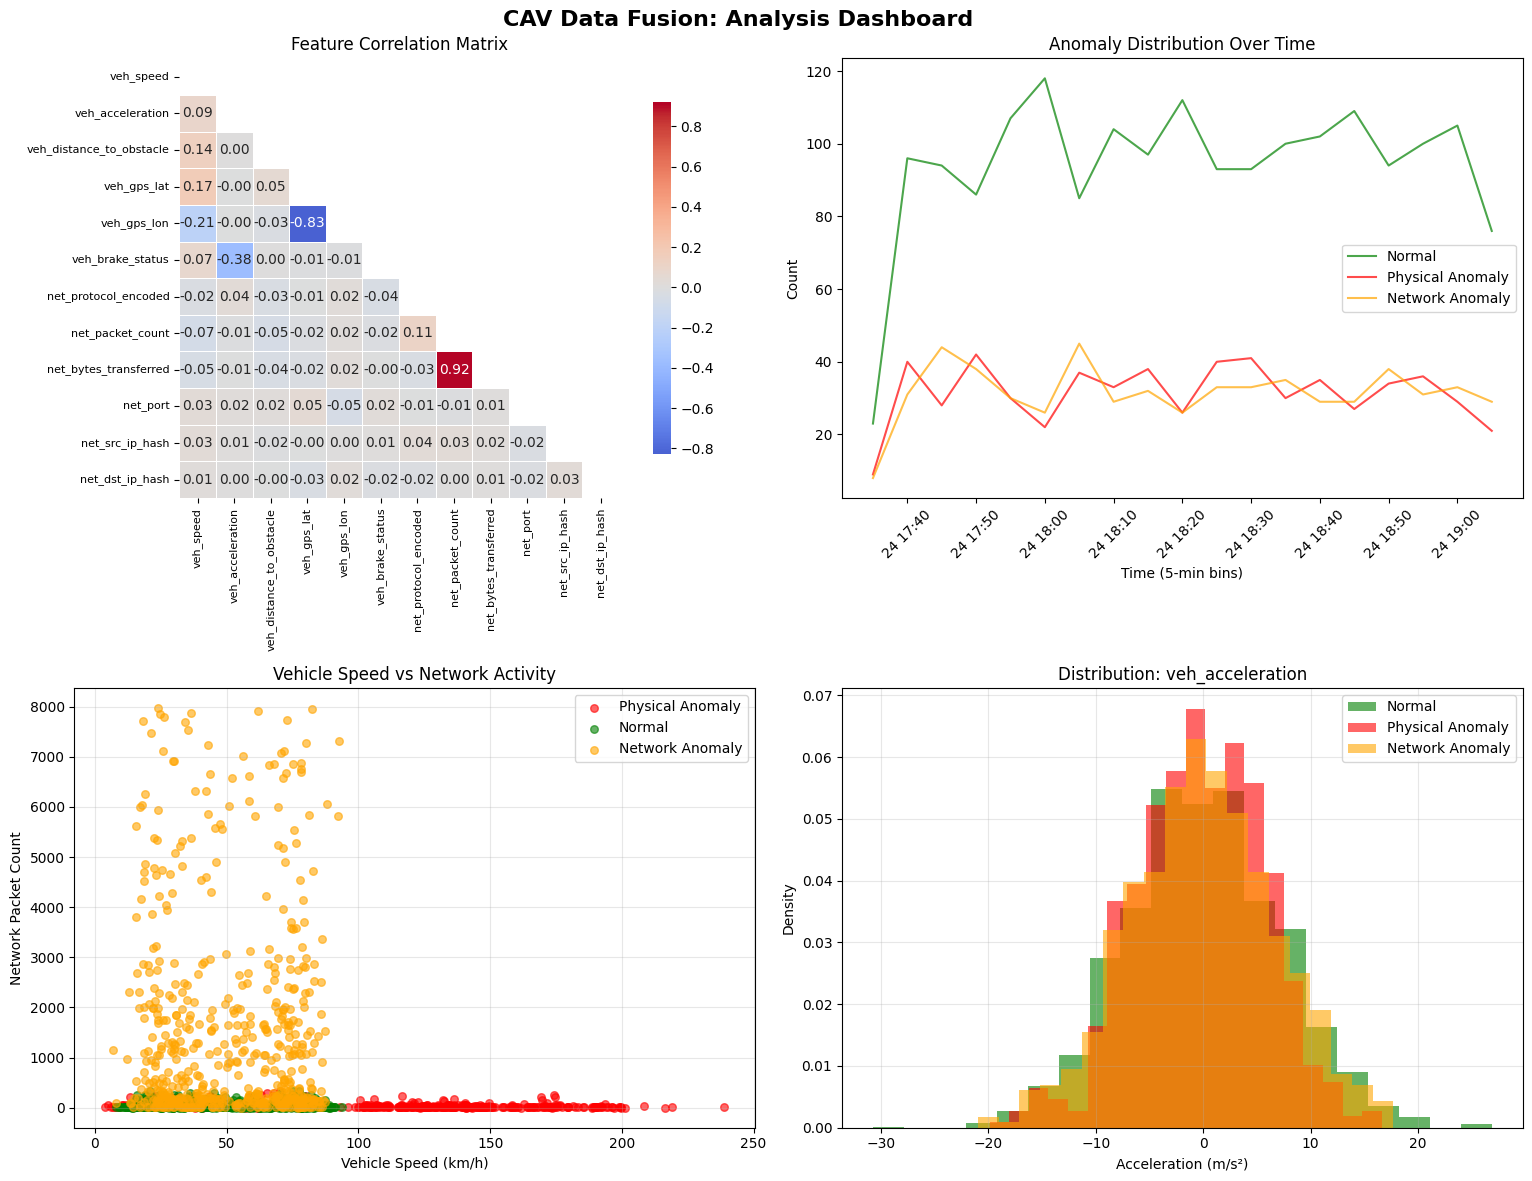


Exploratory Data Analysis Complete!


In [8]:
# Correlation analysis and visualization
def visualize_correlations_and_anomalies(df):
    """
    Create comprehensive visualizations of the fused dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('CAV Data Fusion: Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Feature correlation heatmap
    ax1 = axes[0, 0]
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove non-feature columns
    exclude_cols = ['label', 'time_diff_seconds']
    feature_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    corr_matrix = df[feature_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax1, fmt='.2f')
    ax1.set_title('Feature Correlation Matrix')
    # Improved axis label formatting to prevent overlapping
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    ax1.tick_params(axis='y', rotation=0, labelsize=8)
    # Adjust layout to ensure labels fit properly
    plt.setp(ax1.get_xticklabels(), ha='center')
    
    # 2. Anomaly distribution over time
    ax2 = axes[0, 1]
    # Group by 5-minute intervals
    df['time_bin'] = df['timestamp'].dt.floor('5min')
    time_anomalies = df.groupby(['time_bin', 'label']).size().unstack(fill_value=0)
    
    if 0 in time_anomalies.columns:
        ax2.plot(time_anomalies.index, time_anomalies[0], label='Normal', color='green', alpha=0.7)
    if 1 in time_anomalies.columns:
        ax2.plot(time_anomalies.index, time_anomalies[1], label='Physical Anomaly', color='red', alpha=0.7)
    if 2 in time_anomalies.columns:
        ax2.plot(time_anomalies.index, time_anomalies[2], label='Network Anomaly', color='orange', alpha=0.7)
    
    ax2.set_title('Anomaly Distribution Over Time')
    ax2.set_xlabel('Time (5-min bins)')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Vehicle speed vs. Network activity by anomaly type
    ax3 = axes[1, 0]
    colors = {0: 'green', 1: 'red', 2: 'orange'}
    labels = {0: 'Normal', 1: 'Physical Anomaly', 2: 'Network Anomaly'}
    
    for label_val in df['label'].unique():
        subset = df[df['label'] == label_val]
        ax3.scatter(subset['veh_speed'], subset['net_packet_count'], 
                   c=colors[label_val], label=labels[label_val], alpha=0.6, s=30)
    
    ax3.set_title('Vehicle Speed vs Network Activity')
    ax3.set_xlabel('Vehicle Speed (km/h)')
    ax3.set_ylabel('Network Packet Count')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Anomaly feature distribution comparison
    ax4 = axes[1, 1]
    
    # Compare key features across anomaly types
    feature_to_analyze = 'veh_acceleration'  # Can be changed to any feature
    
    for label_val in sorted(df['label'].unique()):
        subset = df[df['label'] == label_val][feature_to_analyze]
        ax4.hist(subset, bins=20, alpha=0.6, label=labels[label_val], 
                color=colors[label_val], density=True)
    
    ax4.set_title(f'Distribution: {feature_to_analyze}')
    ax4.set_xlabel('Acceleration (m/s²)')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Clean up temporary column
    df.drop('time_bin', axis=1, inplace=True)

# Create comprehensive visualizations
visualize_correlations_and_anomalies(final_dataset)

print("\nExploratory Data Analysis Complete!")

## Step 5: Feature Normalization and Final Dataset Preparation

Before saving the final dataset, we'll normalize numerical features to ensure they're ready for machine learning models.

In [9]:
def normalize_features(df, exclude_cols=['timestamp', 'label', 'time_diff_seconds']):
    """
    Normalize numerical features using StandardScaler
    
    Parameters:
    - df: Input dataset
    - exclude_cols: Columns to exclude from normalization
    
    Returns:
    - Normalized dataset and fitted scaler
    """
    print("Normalizing numerical features...")
    
    df_normalized = df.copy()
    
    # Identify numerical columns to normalize
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_normalize = [col for col in numerical_cols if col not in exclude_cols]
    
    print(f"   Features to normalize: {cols_to_normalize}")
    
    # Apply StandardScaler
    scaler = StandardScaler()
    df_normalized[cols_to_normalize] = scaler.fit_transform(df_normalized[cols_to_normalize])
    
    print(f"   Normalized {len(cols_to_normalize)} features")
    print(f"   Features now have mean≈0 and std≈1")
    
    return df_normalized, scaler

# Normalize the dataset
final_normalized_dataset, feature_scaler = normalize_features(final_dataset)

# Show normalization results
print("\nNormalization Results:")
numerical_cols = final_normalized_dataset.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numerical_cols if col not in ['label', 'time_diff_seconds']]

norm_stats = final_normalized_dataset[feature_cols].agg(['mean', 'std']).round(4)
print(norm_stats)

print(f"\nFinal Dataset Ready: {final_normalized_dataset.shape}")

Normalizing numerical features...
   Features to normalize: ['veh_speed', 'veh_acceleration', 'veh_distance_to_obstacle', 'veh_gps_lat', 'veh_gps_lon', 'veh_brake_status', 'net_protocol_encoded', 'net_packet_count', 'net_bytes_transferred', 'net_port', 'net_src_ip_hash', 'net_dst_ip_hash']
   Normalized 12 features
   Features now have mean≈0 and std≈1

Normalization Results:
      veh_speed  veh_acceleration  veh_distance_to_obstacle  veh_gps_lat  \
mean    -0.0000           -0.0000                   -0.0000      -0.0000   
std      1.0002            1.0002                    1.0002       1.0002   

      veh_gps_lon  veh_brake_status  net_protocol_encoded  net_packet_count  \
mean       0.0000            0.0000               -0.0000            0.0000   
std        1.0002            1.0002                1.0002            1.0002   

      net_bytes_transferred  net_port  net_src_ip_hash  net_dst_ip_hash  
mean                 0.0000    0.0000           0.0000           0.0000  
std   

## Step 6: Save Final Dataset

Save the preprocessed, fused, and normalized dataset for use in subsequent machine learning workflows.

In [10]:
# Prepare final dataset for export
def prepare_final_export(df):
    """
    Prepare the final dataset for export with proper column ordering and metadata
    """
    print("Preparing final dataset for export...")
    
    export_df = df.copy()
    
    # Reorder columns logically
    ordered_columns = ['timestamp', 'label']
    
    # Add vehicle features
    vehicle_cols = [col for col in export_df.columns if col.startswith('veh_')]
    ordered_columns.extend(sorted(vehicle_cols))
    
    # Add network features
    network_cols = [col for col in export_df.columns if col.startswith('net_')]
    ordered_columns.extend(sorted(network_cols))
    
    # Add any remaining columns
    remaining_cols = [col for col in export_df.columns if col not in ordered_columns]
    ordered_columns.extend(remaining_cols)
    
    export_df = export_df[ordered_columns]
    
    print(f"   Final column order: {list(export_df.columns)}")
    
    return export_df

# Prepare and save the final dataset
final_export_dataset = prepare_final_export(final_normalized_dataset)

# Save to CSV
output_filename = 'combined_dataset.csv'
final_export_dataset.to_csv(output_filename, index=False)

print(f"\nDATASET SAVED SUCCESSFULLY!")
print(f"   Filename: {output_filename}")
print(f"   Shape: {final_export_dataset.shape}")
print(f"   File size: {round(final_export_dataset.memory_usage(deep=True).sum() / 1024**2, 2)} MB")

# Final summary
print(f"\nFINAL DATASET SUMMARY")
print("=" * 50)
print(f"Total Records: {len(final_export_dataset):,}")
print(f"Total Features: {len(final_export_dataset.columns)-2} (excluding timestamp & label)")
print(f"Vehicle Features: {len([c for c in final_export_dataset.columns if c.startswith('veh_')])}")
print(f"Network Features: {len([c for c in final_export_dataset.columns if c.startswith('net_')])}")

# Label distribution
label_counts = final_export_dataset['label'].value_counts().sort_index()
print(f"\nLabel Distribution:")
print(f"   Normal (0): {label_counts.get(0, 0):,} records ({label_counts.get(0, 0)/len(final_export_dataset)*100:.1f}%)")
print(f"   Physical Anomaly (1): {label_counts.get(1, 0):,} records ({label_counts.get(1, 0)/len(final_export_dataset)*100:.1f}%)")
print(f"   Network Anomaly (2): {label_counts.get(2, 0):,} records ({label_counts.get(2, 0)/len(final_export_dataset)*100:.1f}%)")

print(f"\nDataset ready for Edge AI model training in next notebook!")

Preparing final dataset for export...
   Final column order: ['timestamp', 'label', 'veh_acceleration', 'veh_brake_status', 'veh_distance_to_obstacle', 'veh_gps_lat', 'veh_gps_lon', 'veh_speed', 'net_bytes_transferred', 'net_dst_ip_hash', 'net_packet_count', 'net_port', 'net_protocol_encoded', 'net_src_ip_hash', 'time_diff_seconds']

DATASET SAVED SUCCESSFULLY!
   Filename: combined_dataset.csv
   Shape: (2991, 15)
   File size: 0.34 MB

FINAL DATASET SUMMARY
Total Records: 2,991
Total Features: 13 (excluding timestamp & label)
Vehicle Features: 6
Network Features: 6

Label Distribution:
   Normal (0): 1,794 records (60.0%)
   Physical Anomaly (1): 598 records (20.0%)
   Network Anomaly (2): 599 records (20.0%)

Dataset ready for Edge AI model training in next notebook!
